In [77]:
import time
import os
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
browser = webdriver.Chrome()
url = ["https://medium.com/topic/data-science", "https://medium.com/topic/artificial-intelligence"]
browser.get("https://medium.com/topic/data-science")
time.sleep(1)

### Fetch all links on that page and filter them out

In [78]:
all_posts = []
for u in url:
    
    browser.get(u)
    time.sleep(1)
    
    elem = browser.find_element_by_tag_name('body')
    # print(elem)

    no_of_pagedowns = 3000

    while no_of_pagedowns:
        elem.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.2)
        no_of_pagedowns-=1


    post_elems = browser.find_elements_by_tag_name("a")

    # for post in post_elems:
    #     print(post.get_attribute('href'), len (post.get_attribute('href')))
    post_relevant = [post for post in post_elems if len(post.get_attribute('href')) > 100]  
    for i in range(0, len(post_relevant), 3):
        all_posts.append(post_relevant[i].get_attribute('href'))
    len(all_posts)

### Iterate over every link and fetch relevant data

In [79]:
len(all_posts)

819

In [92]:
i = 643
r  = requests.get(all_posts[i])
data = r.text
soup = BeautifulSoup(data, 'html.parser')

In [93]:
soup.find('button', class_="button button--chromeless u-baseColor--buttonNormal js-multirecommendCountButton").text


AttributeError: 'NoneType' object has no attribute 'text'

In [24]:
# data_scrapped.loc[i-1,'title'] = soup.title.text[0:-23]
# data_scrapped.loc[i-1,'claps'] = soup.find('button', class_="button button--chromeless u-baseColor--buttonNormal js-multirecommendCountButton").text
# format = "%Y-%m-%d"
# data_scrapped.loc[i-1,'datePublished'] =  datetime.strptime(ast.literal_eval(soup.find('script').text)["datePublished"][0:10], format)
# data_scrapped.loc[i-1,'read_time'] = soup.find("span",class_ = "readingTime")['title'][:-9]
# para.append( [hit.text.strip() for hit in soup.find_all('p')])
# tags.append( ast.literal_eval(soup.find('script').text)["keywords"])
# bullets.append( [hit.text.strip() for hit in soup.select('li[class*="graf graf--li"]')])
# images.append( soup.find_all('img', class_="graf-image"))

In [82]:
import ast
from datetime import datetime
para = []
tags = []
bullets = []
images = []
data_scrapped = pd.DataFrame()
for i in range(1,len(all_posts)):

    r  = requests.get(all_posts[i])
    data = r.text
    soup = BeautifulSoup(data, 'html.parser')
    data_scrapped.loc[i-1,'title'] = soup.title.text[0:-23]
    data_scrapped.loc[i-1,'claps'] = soup.find('button', class_="button button--chromeless u-baseColor--buttonNormal js-multirecommendCountButton").text
    format = "%Y-%m-%d"
    data_scrapped.loc[i-1,'datePublished'] =  datetime.strptime(ast.literal_eval(soup.find('script').text)["datePublished"][0:10], format)
    data_scrapped.loc[i-1,'read_time'] = soup.find("span",class_ = "readingTime")['title'][:-9]
    para.append( [hit.text.strip() for hit in soup.find_all('p')])
    tags.append( ast.literal_eval(soup.find('script').text)["keywords"])
    bullets.append( [hit.text.strip() for hit in soup.select('li[class*="graf graf--li"]')])
    images.append( soup.find_all('img', class_="graf-image"))
    if i%50 == 0:
        print(i)

50
100
150
200
250
300
350
400
450
500
550
600


AttributeError: 'NoneType' object has no attribute 'text'

In [ ]:
data_scrapped['para'] = [[]] * len(data_scrapped)
data_scrapped['tags'] = [[]] * len(data_scrapped)
data_scrapped['bullets'] = [[]] * len(data_scrapped)
data_scrapped['images'] = [[]] * len(data_scrapped)

In [60]:
len(para), len(tags), len(bullets), len(images)

(635, 635, 635, 635)

In [61]:
data_scrapped['para'] = para
data_scrapped['tags'] = tags
data_scrapped['bullets']  = bullets
data_scrapped['images'] = images

In [62]:
data_scrapped.loc[5,'tags']

['Food', 'Data Visualization', 'Asia', 'Culture', '100daysofcode']

In [63]:
data_scrapped.shape

(635, 8)

In [66]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores("you are dumb")

/Users/neerjadoshi/anaconda2/envs/fastai/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [67]:
data = pd.DataFrame()
for i in range(data_scrapped.shape[0]):
    data.loc[i, "title_words"] = len(data_scrapped.loc[i, "title"].split(" "))
    data.loc[i, "days_passed"] = (datetime.now() - data_scrapped.loc[i,'datePublished'] ).days
    data.loc[i, "ct_image"] = len(data_scrapped.loc[i, "images"])
    data.loc[i, "ct_tags"] = len(data_scrapped.loc[i, "tags"])
    text =  " ".join(data_scrapped.loc[i, "para"] + data_scrapped.loc[i, "bullets"]).split()
    data.loc[i, "ct_words"] = len(text)
    data.loc[i, "title_emot_quotient"] = abs(sid.polarity_scores(data_scrapped.loc[i, "title"])['compound'])
    data.loc[i, "featured_in_tds"] = 'Towards Data Science' in data_scrapped.loc[i,'tags']
    data.loc[i,'read_time'] = int(data_scrapped.loc[i,'read_time'])
    

In [68]:
def claps2num(x):
    if "K" in x:
        return float(x.replace("K",""))*1000
    else:
        return int(x)
data['claps'] = data_scrapped['claps'].apply(lambda x: claps2num(x))

In [73]:
data["img/word"] = data['ct_image']/data['ct_words']

In [75]:
data.to_csv("data.csv",index=False)
data_scrapped.to_csv('data_scraped.csv', index = False)

In [76]:
data.head()

,title_words,days_passed,ct_image,ct_tags,ct_words,title_emot_quotient,featured_in_tds,read_time,claps,img/word
0,6.0,1.0,8.0,5.0,2493.0,0.000,True,11.0,683.0,0.003209
1,10.0,1.0,7.0,5.0,2301.0,0.874,True,11.0,696.0,0.003042
2,5.0,2.0,4.0,5.0,547.0,0.000,True,3.0,496.0,0.007313
3,8.0,2.0,2.0,5.0,661.0,0.250,True,3.0,2700.0,0.003026
4,4.0,0.0,5.0,5.0,499.0,0.000,False,3.0,8.0,0.010020


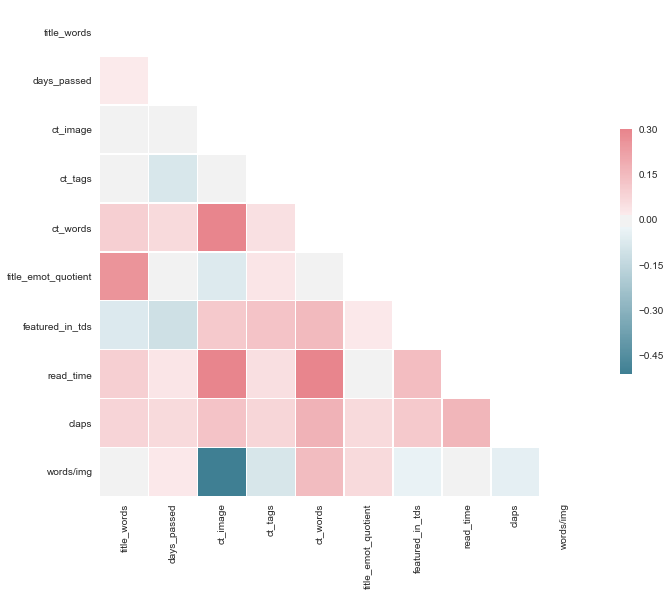

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="white")
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [83]:
i

643